# This notebook is used to mine the EFD to build a LUT

In [1]:
import asyncio 
import matplotlib

import numpy as np
import pandas as pd

from matplotlib import pylab as plt
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient, resample

%matplotlib inline

In [2]:
# Temporarily needed to run at summit
import os
os.environ["LSST_DDS_DOMAIN"] = 'lsatmcs'
os.environ["OSPL_URI"] = "file:///home/patrickingraham/ospl.xml"

In [3]:
efd_client = EfdClient('summit_efd')

Query for all the `endReadout` events on the timespan of the night.

In [7]:
t1 = Time("2020-03-16T23:00", format='isot', scale='tai')
t2 = Time("2020-03-17T03:01", format='isot', scale='tai')#+TimeDelta(8.*24.*60*60., format='sec', scale='tai')

In [8]:
end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                           ["imageName", "exposureTime", "groupId", "imageType"], t1, t2)
label_event = await efd_client.select_time_series("lsst.sal.Script.logevent_logMessage", 
                                           ["message"], t1, t2)

In [12]:
len(label_event)

172

In [13]:
len(end_readout)

125

In [ ]:
for i in range(npairs):
    
    t1 = Time(intra_times[i],                                            scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') - TimeDelta(180., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(1., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)
    hexapod = await efd_client.select_time_series("lsst.sal.ATHexapod.command_moveToPosition",
                                                  ["x", "y", "z", "u", "v", "w"], t1, t2)
    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                                  ["pressure"], t1, t2)
    #offset = await efd_client.select_time_series("lsst.sal.ATAOS.command_applyAxisOffset",
    #                                             ["*"], t1, t2)
    offset = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_hexapodCorrectionCompleted",
                                                 ["hexapod_x", "hexapod_y", "hexapod_z", "hexapod_u", "hexapod_v", "hexapod_w"], t1, t2)
    
    
    
    if len(hexapod) < 2:
         print(f"Could not get hexapod position for pair {i+1}: {intra_images[i]} x {extra_images[i]}")
         continue

    rot_pos = np.mean(rotator['nasmyth2CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    # Need to get most recently commanded hexapod correction position
    # should always be the last two values of an the array (except for 
    # z which will move for intra/extra)
#     x = (hexapod['x'][len(hexapod)-2]+hexapod['x'][len(hexapod)-1])/2.
#     y = (hexapod['y'][len(hexapod)-2]+hexapod['y'][len(hexapod)-1])/2.
#     z = (hexapod['z'][len(hexapod)-2]+hexapod['z'][len(hexapod)-1])/2.
#     u = (hexapod['u'][len(hexapod)-2]+hexapod['u'][len(hexapod)-1])/2.
#     v = (hexapod['v'][len(hexapod)-2]+hexapod['v'][len(hexapod)-1])/2.
#     w = (hexapod['w'][len(hexapod)-2]+hexapod['w'][len(hexapod)-1])/2.

    x = (offset['hexapod_x'][-2]+offset['hexapod_x'][-2])/2.
    y = (offset['hexapod_y'][-2]+offset['hexapod_y'][-2])/2.
    z = (offset['hexapod_z'][-2]+offset['hexapod_z'][-2])/2.
    u = (offset['hexapod_u'][-2]+offset['hexapod_u'][-2])/2.
    v = (offset['hexapod_v'][-2]+offset['hexapod_v'][-2])/2.
    w = (offset['hexapod_w'][-2]+offset['hexapod_w'][-2])/2.

    m1 = np.mean(m1_pressure['pressure'])
    dz = round((offset['hexapod_z'][-1] - offset['hexapod_z'][-2])/2.,3)
    match_data[i] = (f"{intra_images[i]}.fits", f"{extra_images[i]}.fits", az, el, rot_pos, x, y, z, u, u, w, m1, dz)

    print(t1,t2,az, el, rot_pos, x, y, z, u, u, w,dz)
# print("done")

Now match each entry. For each `i` item with `intra` in the name, there must be an `i+1` with `extra` otherwise it is not a pair. 

In [7]:
intra_images = []
extra_images = []
intra_times = []
extra_times = []
intra_exptimes = []
extra_exptimes = []

i = 0
npairs = 0
nmiss = 0

while i < len(end_readout)-1:
    first = end_readout['imageName'][i]
    second = end_readout['imageName'][i+1]
    
    #skip known bad files
    if intra == 'AT_O_20200218_000179' and extra == 'AT_O_20200218_000180':
        i+=2
        continue
    
    if (end_readout['groupId'][i] == end_readout['groupId'][i+1]) and (end_readout['groupId'][i+1] != end_readout['groupId'][i+2]) and (end_readout['imageType'][i] == 'ENGTEST'):
        print(f"Got a pair: {intra} x {extra}")
        intra_images.append(intra)
        extra_images.append(extra)
        intra_times.append(end_readout.index[i])
        extra_times.append(end_readout.index[i+1])
        intra_exptimes.append(end_readout['exposureTime'][i])
        extra_exptimes.append(end_readout['exposureTime'][i+1])
        i+=2
        npairs+=1
    else:
#         print(f"No Match: {intra} x {extra}")
        nmiss+=1
        i+=1

print(f"Got {npairs} pairs and {nmiss} misses.")

Got 0 pairs and 0 misses.


In [ ]:
for i in range(npairs):
    
    t1 = Time(intra_times[i],                                            scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') - TimeDelta(180., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(1., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)
    hexapod = await efd_client.select_time_series("lsst.sal.ATHexapod.command_moveToPosition",
                                                  ["x", "y", "z", "u", "v", "w"], t1, t2)
    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                                  ["pressure"], t1, t2)
    #offset = await efd_client.select_time_series("lsst.sal.ATAOS.command_applyAxisOffset",
    #                                             ["*"], t1, t2)
    offset = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_hexapodCorrectionCompleted",
                                                 ["hexapod_x", "hexapod_y", "hexapod_z", "hexapod_u", "hexapod_v", "hexapod_w"], t1, t2)
    
    
    
    if len(hexapod) < 2:
         print(f"Could not get hexapod position for pair {i+1}: {intra_images[i]} x {extra_images[i]}")
         continue

    rot_pos = np.mean(rotator['nasmyth2CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    # Need to get most recently commanded hexapod correction position
    # should always be the last two values of an the array (except for 
    # z which will move for intra/extra)
#     x = (hexapod['x'][len(hexapod)-2]+hexapod['x'][len(hexapod)-1])/2.
#     y = (hexapod['y'][len(hexapod)-2]+hexapod['y'][len(hexapod)-1])/2.
#     z = (hexapod['z'][len(hexapod)-2]+hexapod['z'][len(hexapod)-1])/2.
#     u = (hexapod['u'][len(hexapod)-2]+hexapod['u'][len(hexapod)-1])/2.
#     v = (hexapod['v'][len(hexapod)-2]+hexapod['v'][len(hexapod)-1])/2.
#     w = (hexapod['w'][len(hexapod)-2]+hexapod['w'][len(hexapod)-1])/2.

    x = (offset['hexapod_x'][-2]+offset['hexapod_x'][-2])/2.
    y = (offset['hexapod_y'][-2]+offset['hexapod_y'][-2])/2.
    z = (offset['hexapod_z'][-2]+offset['hexapod_z'][-2])/2.
    u = (offset['hexapod_u'][-2]+offset['hexapod_u'][-2])/2.
    v = (offset['hexapod_v'][-2]+offset['hexapod_v'][-2])/2.
    w = (offset['hexapod_w'][-2]+offset['hexapod_w'][-2])/2.

    m1 = np.mean(m1_pressure['pressure'])
    dz = round((offset['hexapod_z'][-1] - offset['hexapod_z'][-2])/2.,3)
    match_data[i] = (f"{intra_images[i]}.fits", f"{extra_images[i]}.fits", az, el, rot_pos, x, y, z, u, u, w, m1, dz)

    print(t1,t2,az, el, rot_pos, x, y, z, u, u, w,dz)
# print("done")

In [8]:
match_data = np.zeros(npairs, dtype=[('intra', '<U35'), 
                                     ('extra', '<U35'), 
                                     ('az', float), 
                                           ('el', float), 
                                           ('rot_pos', float),
                                           ('x', float), 
                                           ('y', float), 
                                           ('z', float), 
                                           ('u', float), 
                                           ('v', float), 
                                           ('w', float), 
                                     ('m1_pressure', float),
                                     ('dz', float)])

In [9]:
for i in range(npairs):
    
    t1 = Time(intra_times[i],                                            scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') - TimeDelta(180., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(1., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)
    hexapod = await efd_client.select_time_series("lsst.sal.ATHexapod.command_moveToPosition",
                                                  ["x", "y", "z", "u", "v", "w"], t1, t2)
    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                                  ["pressure"], t1, t2)
    #offset = await efd_client.select_time_series("lsst.sal.ATAOS.command_applyAxisOffset",
    #                                             ["*"], t1, t2)
    offset = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_hexapodCorrectionCompleted",
                                                 ["hexapod_x", "hexapod_y", "hexapod_z", "hexapod_u", "hexapod_v", "hexapod_w"], t1, t2)
    
    
    
    if len(hexapod) < 2:
         print(f"Could not get hexapod position for pair {i+1}: {intra_images[i]} x {extra_images[i]}")
         continue

    rot_pos = np.mean(rotator['nasmyth2CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    # Need to get most recently commanded hexapod correction position
    # should always be the last two values of an the array (except for 
    # z which will move for intra/extra)
#     x = (hexapod['x'][len(hexapod)-2]+hexapod['x'][len(hexapod)-1])/2.
#     y = (hexapod['y'][len(hexapod)-2]+hexapod['y'][len(hexapod)-1])/2.
#     z = (hexapod['z'][len(hexapod)-2]+hexapod['z'][len(hexapod)-1])/2.
#     u = (hexapod['u'][len(hexapod)-2]+hexapod['u'][len(hexapod)-1])/2.
#     v = (hexapod['v'][len(hexapod)-2]+hexapod['v'][len(hexapod)-1])/2.
#     w = (hexapod['w'][len(hexapod)-2]+hexapod['w'][len(hexapod)-1])/2.

    x = (offset['hexapod_x'][-2]+offset['hexapod_x'][-2])/2.
    y = (offset['hexapod_y'][-2]+offset['hexapod_y'][-2])/2.
    z = (offset['hexapod_z'][-2]+offset['hexapod_z'][-2])/2.
    u = (offset['hexapod_u'][-2]+offset['hexapod_u'][-2])/2.
    v = (offset['hexapod_v'][-2]+offset['hexapod_v'][-2])/2.
    w = (offset['hexapod_w'][-2]+offset['hexapod_w'][-2])/2.

    m1 = np.mean(m1_pressure['pressure'])
    dz = round((offset['hexapod_z'][-1] - offset['hexapod_z'][-2])/2.,3)
    match_data[i] = (f"{intra_images[i]}.fits", f"{extra_images[i]}.fits", az, el, rot_pos, x, y, z, u, u, w, m1, dz)

    print(t1,t2,az, el, rot_pos, x, y, z, u, u, w,dz)
# print("done")

In [10]:
df = pd.DataFrame(match_data)

In [11]:
# for i in range(len(df)):
#     print(f"{df['intra'][i]}: {df['el'][i]+df['rot_pos'][i]}: dz={df['dz'][i]}")
# # df['intra'],df['el']+df['rot_pos']

In [12]:
df.to_csv("20200123_match.csv")

# Now reduce the data for each pair to get the zernikes from fitting

In [25]:
#df2 = pd.DataFrame.from_csv("20200123_match.csv")
df2 = pd.read_csv("20200123_match.csv")
# but need to add all the zernike terms from teh fitting
df2['zern_defocus_nm'] = np.zeros(len(df2))
df2['zern_xastig_nm'] = np.zeros(len(df2))
df2['zern_yastig_nm'] = np.zeros(len(df2))
df2['zern_xcoma_nm'] = np.zeros(len(df2))
df2['zern_ycoma_nm'] = np.zeros(len(df2))
df2['zern_xtrefoil_nm'] = np.zeros(len(df2))
df2['zern_ytrefoil_nm'] = np.zeros(len(df2))
df2['zern_sphereical_nm'] = np.zeros(len(df2))


In [26]:
# match_data = np.zeros(npairs, dtype=[('intra', '<U35'), 
#                                      ('extra', '<U35'), 
#                                      ('az', float), 
#                                            ('el', float), 
#                                            ('rot_pos', float),
#                                            ('x', float), 
#                                            ('y', float), 
#                                            ('z', float), 
#                                            ('u', float), 
#                                            ('v', float), 
#                                            ('w', float), 
#                                      ('m1_pressure', float),
#                                      ('dz', float),
#                                     ('zern_defocus_nm', float),
#                                     ('zern_xastig_nm', float),
#                                     ('zern_yastig_nm', float),
#                                     ('zern_xcoma_nm', float),
#                                     ('zern_ycoma_nm', float),
#                                     ('zern_xtrefoil_nm', float),
#                                     ('zern_ytrefoil_nm', float),
#                                     ('zern_sphereical_nm', float),])

In [27]:
# Requires new pandas version to use
# df2 = pd.DataFrame.read_csv("20200123_match.csv")

In [28]:
import sys
import asyncio
import logging
import numpy as np
import matplotlib.pyplot as plt
from lsst.ts.externalscripts.auxtel.latiss_cwfs_align import LatissCWFSAlign
import time

In [29]:
script = LatissCWFSAlign(index=1, remotes=False)

In [30]:
script.dataPath='/project/shared/auxTel/'

In [31]:
def get_visitID_from_filename(filename):
    # Expects AT_O_20200218_000167.fits
    # parse out visitID from filename - this is highly annoying
    tmp=filename.split('_')
    prefix=tmp[2] # dayobs without the dashes

    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('.')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    #print(visitID)
    return visitID

Read historical data in 0.01 sec


In [32]:
# for logging
stream_handler = logging.StreamHandler(sys.stdout)
# if you want logging
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [33]:
for n in range(len(df2)):
#for n in [len(df2)-2]:   
    script.angle = 0.
    script.intra_visit_id = get_visitID_from_filename(df2['intra'][n])
    script.extra_visit_id = get_visitID_from_filename(df2['extra'][n])

    start_time=time.time()
    await script.run_cwfs()
    end_time=time.time()
    print('WFE fitting for visitIDs {0} and {1} took {2:0.3f} seconds'.format(script.intra_visit_id, script.extra_visit_id,end_time-start_time)) # 56.7s

    # Display fitting results?
    if (True):
        # plot zernikes
        x = np.arange(9)+4
        plt.plot(x, script.algo.zer4UpNm[:9], 'o-', label=f'{script.dz}')
        xlim = plt.xlim()
        plt.plot(np.arange(15), np.zeros(15)+50, 'b--')
        plt.plot(np.arange(15), np.zeros(15)-50, 'b--')
        plt.xlim(xlim)
        plt.ylabel("Zernike coeff (nm)")
        plt.xlabel("Zernike index")
        plt.grid()
        plt.legend()
        
    if (True):
        # plot image and mask
        fig1 = plt.figure(2, figsize=(12,8))
        ax11 = fig1.add_subplot(121)
        ax11.set_title("defocus 0.8 - intra")
        ax11.imshow(script.I1[0].image0)
        ax11.contour(script.algo.pMask) 
        ax12 = fig1.add_subplot(122)
        ax12.set_title("defocus 0.8 - extra")
        ax12.imshow(script.I2[0].image0)
        ax12.contour(script.algo.pMask) 
        
    # Put results into data structure
    # This will throw errors but don't know how to do this properly!
    df2['zern_defocus_nm'][n] = script.algo.zer4UpNm[0]
    df2['zern_xastig_nm'][n] = script.algo.zer4UpNm[1]
    df2['zern_yastig_nm'][n] = script.algo.zer4UpNm[2]
    df2['zern_xcoma_nm'][n] = script.algo.zer4UpNm[3]
    df2['zern_ycoma_nm'][n]= script.algo.zer4UpNm[4]
    df2['zern_xtrefoil_nm'][n] = script.algo.zer4UpNm[5]
    df2['zern_ytrefoil_nm'][n] = script.algo.zer4UpNm[6]
    df2['zern_sphereical_nm'][n] = script.algo.zer4UpNm[7]


Running cwfs in 2020021800167/2020021800168.
Running cwfs in 2020021800167/2020021800168.


/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140126294275840 and this is thread id 140123623368448.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
AT_O_20200218_000167: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000167: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000167: Forcing SHUTTIME header to be None
AT_O_20200218_000167: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
AT_O_20200218_000167: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000167: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000167: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000167:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False


Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
AT_O_20200218_000168: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000168: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000168: Forcing SHUTTIME header to be None
AT_O_20200218_000168: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
AT_O_20200218_000168: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000168: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000168: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000168:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
AT_O_20200218_000169: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000169: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000169: Forcing SHUTTIME header to be None
AT_O_20200218_000169: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
AT_O_20200218_000169: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000169: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000169: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000169:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False


Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
AT_O_20200218_000170: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000170: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000170: Forcing SHUTTIME header to be None
AT_O_20200218_000170: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
AT_O_20200218_000170: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000170: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000170: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000170:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
AT_O_20200218_000171: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000171: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000171: Forcing SHUTTIME header to be None
AT_O_20200218_000171: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
AT_O_20200218_000171: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000171: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000171: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000171:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False


Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
AT_O_20200218_000172: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000172: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000172: Forcing SHUTTIME header to be None
AT_O_20200218_000172: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
AT_O_20200218_000172: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000172: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000172: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000172:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
AT_O_20200218_000173: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000173: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000173: Forcing SHUTTIME header to be None
AT_O_20200218_000173: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
AT_O_20200218_000173: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000173: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000173: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000173:

Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140123588241152 and this is thread id 140123623368448.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140123588241152 and this is thread id 140123623368448.
Exception ignore

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
AT_O_20200218_000174: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000174: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000174: Forcing SHUTTIME header to be None
AT_O_20200218_000174: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
AT_O_20200218_000174: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000174: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000174: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000174:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
AT_O_20200218_000175: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000175: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000175: Forcing SHUTTIME header to be None
AT_O_20200218_000175: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
AT_O_20200218_000175: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000175: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000175: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000175:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140123623368448 and this is thread id 140120363054848.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
AT_O_20200218_000176: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000176: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000176: Forcing SHUTTIME header to be None
AT_O_20200218_000176: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
AT_O_20200218_000176: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000176: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000176: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000176:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
AT_O_20200218_000177: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000177: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000177: Forcing SHUTTIME header to be None
AT_O_20200218_000177: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
AT_O_20200218_000177: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000177: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000177: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000177:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140120363054848 and this is thread id 140123623368448.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
AT_O_20200218_000178: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000178: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000178: Forcing SHUTTIME header to be None
AT_O_20200218_000178: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
AT_O_20200218_000178: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000178: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000178: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000178:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
AT_O_20200218_000181: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000181: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000181: Forcing SHUTTIME header to be None
AT_O_20200218_000181: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
AT_O_20200218_000181: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000181: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000181: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000181:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140123623368448 and this is thread id 140120354662144.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
AT_O_20200218_000182: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000182: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000182: Forcing SHUTTIME header to be None
AT_O_20200218_000182: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
AT_O_20200218_000182: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000182: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000182: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000182:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
AT_O_20200218_000184: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000184: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000184: Forcing SHUTTIME header to be None
AT_O_20200218_000184: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
AT_O_20200218_000184: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000184: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000184: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000184:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140120354662144 and this is thread id 140123623368448.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
AT_O_20200218_000185: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000185: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000185: Forcing SHUTTIME header to be None
AT_O_20200218_000185: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
AT_O_20200218_000185: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000185: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000185: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000185:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
AT_O_20200218_000187: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000187: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000187: Forcing SHUTTIME header to be None
AT_O_20200218_000187: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
AT_O_20200218_000187: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000187: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000187: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000187:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140123623368448 and this is thread id 140120354662144.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
AT_O_20200218_000188: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000188: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000188: Forcing SHUTTIME header to be None
AT_O_20200218_000188: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
AT_O_20200218_000188: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000188: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000188: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000188:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
AT_O_20200218_000190: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000190: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000190: Forcing SHUTTIME header to be None
AT_O_20200218_000190: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
AT_O_20200218_000190: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000190: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000190: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000190:

/home/patrickingraham/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140120354662144 and this is thread id 140123623368448.
Exception ignored in: <function SqlRegistry.__del__ at 0x7f71ec5e5c20>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7

Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
AT_O_20200218_000191: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000191: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000191: Forcing SHUTTIME header to be None
AT_O_20200218_000191: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
AT_O_20200218_000191: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000191: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
Using translation class LSST_LATISS
AT_O_20200218_000191: Dark time less than exposure time. Setting dark time to the exposure time.
AT_O_20200218_000191:

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

In [35]:
#write to CSV file
df2.to_csv("20200123_match_zerns.csv")

# Fit the data

In [36]:
from scipy.optimize import curve_fit

In [37]:
def parabola(x,b, x0, a):
    return b + a*(x-x0)**2 
def line(x,b, m):
    return b + m*x 
def invparabola(y,b,x0,a):
    return x0+np.sqrt((y-b)/a)
def invline(y,b,m):
    return (y-b)/m

In [40]:
#df3 = pd.DataFrame.from_csv("20200123_match_zerns.csv")
# use below for pandas 1.0+
df3 = pd.read_csv("20200123_match_zerns.csv")

In [41]:
df3

,Unnamed: 0,Unnamed: 0.1,intra,extra,az,el,rot_pos,x,y,z,...,m1_pressure,dz,zern_defocus_nm,zern_xastig_nm,zern_yastig_nm,zern_xcoma_nm,zern_ycoma_nm,zern_xtrefoil_nm,zern_ytrefoil_nm,zern_sphereical_nm
0,0,0,AT_O_20200218_000167.fits,AT_O_20200218_000168.fits,170.579986,64.508060,59.114450,-5.444469,0.913043,-0.502841,...,113614.719766,0.8,12.366351,1.963587,-11.443696,40.333238,-67.107995,36.158523,-35.876717,17.396918
1,1,1,AT_O_20200218_000169.fits,AT_O_20200218_000170.fits,172.478735,64.694430,61.664930,-5.446219,1.211676,-0.502841,...,113764.732608,0.8,-10.667994,3.804069,-18.136925,51.289081,-26.428797,63.511957,-28.721361,24.352589
2,2,2,AT_O_20200218_000171.fits,AT_O_20200218_000172.fits,173.043237,64.743207,63.087051,-5.446632,1.511353,-0.502841,...,113846.624105,0.8,-21.432916,-2.936966,-43.494192,48.550486,29.820427,51.331092,-29.959108,21.659924
3,3,3,AT_O_20200218_000173.fits,AT_O_20200218_000174.fits,173.634219,64.787666,62.137377,-5.447021,1.811049,-0.502841,...,113901.389511,0.8,-23.614912,17.726792,-14.062785,73.169166,95.438332,33.915179,-27.737113,19.452332
4,4,4,AT_O_20200218_000175.fits,AT_O_20200218_000176.fits,174.200182,64.826331,61.233113,-5.447364,2.110781,-0.502841,...,113946.828349,0.8,0.514059,27.133395,14.547694,83.985412,137.764606,24.119209,-32.482272,8.847944
5,5,5,AT_O_20200218_000177.fits,AT_O_20200218_000178.fits,175.039142,64.876694,59.906060,-5.447800,0.610441,-0.502841,...,114030.058860,0.8,53.153634,23.670125,24.026761,56.047431,-79.958337,27.016336,-31.669337,6.420318
6,6,6,AT_O_20200218_000181.fits,AT_O_20200218_000182.fits,176.210051,64.933313,58.060581,-5.448286,0.310061,-0.502841,...,114067.651771,0.8,101.504682,43.140998,53.459085,43.936775,-127.711150,23.659811,-35.370269,0.796691
7,7,7,AT_O_20200218_000184.fits,AT_O_20200218_000185.fits,177.135996,64.966561,56.618520,-5.448561,0.009846,-0.502841,...,114060.464551,0.8,153.080347,33.978086,101.961073,40.431997,-175.629936,34.330570,-29.309529,-1.989328
8,8,8,AT_O_20200218_000187.fits,AT_O_20200218_000188.fits,177.859996,64.984560,55.500086,-5.448698,-0.290261,-0.502841,...,114086.083107,0.8,166.678059,62.802746,95.633256,28.206733,-223.139187,31.443715,-35.873811,-3.954216
9,9,9,AT_O_20200218_000190.fits,AT_O_20200218_000191.fits,178.967945,65.003326,59.549409,-5.448863,0.909610,-0.502841,...,114076.081051,0.8,151.332235,20.112146,93.655066,64.692319,-24.315092,47.495922,-25.218386,-3.522487


### Plot Y-Coma as a function of Y-hexapod decentering

Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
NumExpr defaulting to 8 threads.
Wavefront X-Coma as a function of Hexapod displacement [-179.63851761  141.6727644 ]


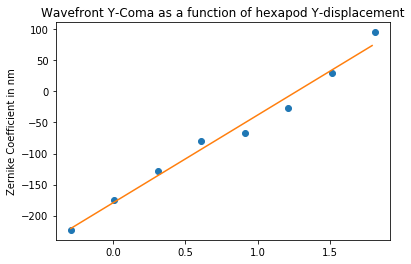

[-179.63851761  141.6727644 ]


In [42]:
inds = np.arange(0,10) # drop the last value
inds = [0,1,2,3,5,6,7,8]

xdata=df3['y'][inds]
ydata=df3['zern_ycoma_nm'][inds]

plt.plot(xdata,ydata,'o')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
popt,pcov = curve_fit(line, xdata, ydata)
print('Wavefront X-Coma as a function of Hexapod displacement',popt)

plt.plot(x,line(x, *popt))
# plt.xlabel('Hexapod displacement in the plane')
plt.ylabel('Zernike Coefficient in nm')
plt.title('Wavefront Y-Coma as a function of hexapod Y-displacement')
plt.show()

print(popt)

In [43]:
(240+200)/ (-6 - -3)

-146.66666666666666

### Plot Defocus as a function of Y-hexapod decentering

Wavefront X-Coma as a function of Hexapod displacement [ 131.7862689  -102.38240023]


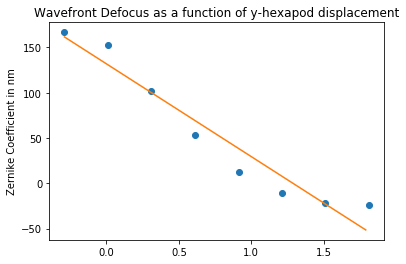

[ 131.7862689  -102.38240023]


In [44]:
#Coma as a function of x,y offset (8-23, 31-35)
inds = np.arange(0,11)
inds = [0,1,2,3,5,6,7,8]

xdata=df3['y'][inds]
ydata=df3['zern_defocus_nm'][inds]

plt.plot(xdata,ydata,'o')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
popt,pcov = curve_fit(line, xdata, ydata)
print('Wavefront X-Coma as a function of Hexapod displacement',popt)

plt.plot(x,line(x, *popt))
# plt.xlabel('Hexapod displacement in the plane')
plt.ylabel('Zernike Coefficient in nm')
plt.title('Wavefront Defocus as a function of y-hexapod displacement')
plt.show()

print(popt)